In [1]:
import numpy as np
import pandas as pd
import os
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

Using TensorFlow backend.


In [2]:
def load_model(filename, verbose=False):
    json_file = open(filename + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    if verbose:
        print("The following model " + filename + " has been loaded")
    return loaded_model

In [3]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [4]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [5]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [6]:
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features

In [7]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [8]:
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [9]:
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [10]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [11]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [12]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

## Prepare train set

In [13]:
train_filename = '../../datasets/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(train_filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [14]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [15]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [16]:
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Prepare test set

In [17]:
test_filename = '../../datasets/flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(test_filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [18]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [19]:
#change features.pkl in case of using inceptionV3 
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

Photos: test=1000


# Evaluate model

In [28]:
model_filename = './model_weights/model_lstm_end_3'
model = load_model(model_filename)

In [29]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.576892
BLEU-2: 0.330481
BLEU-3: 0.235706
BLEU-4: 0.118113


In [111]:
# modelAtt_2
# BLEU-1: 0.577624
# BLEU-2: 0.334999
# BLEU-3: 0.232525
# BLEU-4: 0.112670

In [61]:
# model_lstm_end_5
# BLEU-1: 0.567917
# BLEU-2: 0.327101
# BLEU-3: 0.230917
# BLEU-4: 0.112000

In [ ]:
model_lstm_end_3 lemmatized
BLEU-1: 0.607223
BLEU-2: 0.351466
BLEU-3: 0.251055
BLEU-4: 0.128617

In [57]:
model_lstm_end_3
BLEU-1: 0.576892
BLEU-2: 0.330481
BLEU-3: 0.235706
BLEU-4: 0.118113

In [ ]:
# model_lstm_end_0
# BLEU-1: 0.589627
# BLEU-2: 0.338072
# BLEU-3: 0.232253
# BLEU-4: 0.109980

In [32]:
# model_lstm_2_9
# BLEU-1: 0.550192
# BLEU-2: 0.308358
# BLEU-3: 0.217599
# BLEU-4: 0.107457

In [28]:
# model_lstm_2_5
# BLEU-1: 0.543121
# BLEU-2: 0.301569
# BLEU-3: 0.209945
# BLEU-4: 0.099759

In [ ]:
# model_lstm_2_3
# BLEU-1: 0.562641
# BLEU-2: 0.318167
# BLEU-3: 0.222843
# BLEU-4: 0.107840

In [ ]:
# model_concat_9
# BLEU-1: 0.474946
# BLEU-2: 0.220720
# BLEU-3: 0.138319
# BLEU-4: 0.054092

In [ ]:
# model_concat_5
# BLEU-1: 0.555860
# BLEU-2: 0.279278
# BLEU-3: 0.180292
# BLEU-4: 0.077575

In [ ]:
# model_concat_3
# BLEU-1: 0.552638
# BLEU-2: 0.289466
# BLEU-3: 0.186328
# BLEU-4: 0.080312

In [ ]:
# model_3
# BLEU-1: 0.578345
# BLEU-2: 0.325348
# BLEU-3: 0.226961
# BLEU-4: 0.111016

In [ ]:
# model_5
# BLEU-1: 0.569996
# BLEU-2: 0.319198
# BLEU-3: 0.222908
# BLEU-4: 0.110318

In [ ]:
# model_9
# BLEU-1: 0.547792
# BLEU-2: 0.302444
# BLEU-3: 0.209226
# BLEU-4: 0.102418

In [ ]:
# model_11
# BLEU-1: 0.535853
# BLEU-2: 0.287559
# BLEU-3: 0.199070
# BLEU-4: 0.097181

In [ ]:
# # photo features
# test_features = load_photo_features('../input/flirck-8k-dataset-explore-image-resnet/features.pkl', test)
# print('Resnet\nPhotos: test=%d' % len(test_features))

# # load the model
# filename = '../input/development-model-resnet50/model_19.h5'
# model = load_model(filename)
# # evaluate model
# evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

### Evaluate model - lemmatize

In [21]:
import nltk
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentense(sentence):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

In [39]:
def evaluate_model_lemmatized(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
#         print([lemmatize_sentense(' '.join(lst)) for lst in references])
#         print(lemmatize_sentense(yhat))
        actual.append([lemmatize_sentense(' '.join(lst)) for lst in references])
        predicted.append(lemmatize_sentense(yhat))
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [40]:
evaluate_model_lemmatized(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.607223
BLEU-2: 0.351466
BLEU-3: 0.251055
BLEU-4: 0.128617


## Evaluate model on one image

In [107]:
import matplotlib.pyplot as plt
def plot_image(filename):
    x=plt.imread(filename)
    plt.imshow(x)
    plt.show()

In [108]:
def print_references(references):
    refs = [' '.join(elem)[9:-7] for elem in references]
    for ref in refs:
        print("Reference: ", ref)

In [109]:
def calculate_bleu_score(references, candidate):
    cand = candidate[1:-1]
    refs = [re[1:-1] for re in references]
    print("Bleu_1 score: ",sentence_bleu(refs,cand, weights=(1.0, 0, 0, 0)))
    print("Bleu_2 score: ",sentence_bleu(refs,cand, weights=(0.5, 0.5, 0, 0)))
    print("Bleu_3 score: ",sentence_bleu(refs,cand, weights=(0.3, 0.3, 0.3, 0)))
    print("Bleu_4 score: ",sentence_bleu(refs,cand, weights=(0.25, 0.25, 0.25, 0.25)))


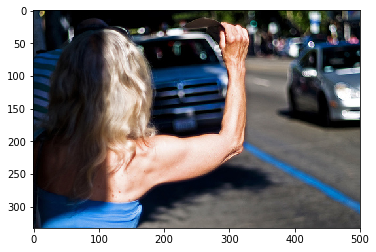

Candidate:  man in black shirt is sitting on bench 
Reference:  blond woman in blue shirt appears to wait for ride
Reference:  blond woman is on the street hailing taxi
Reference:  woman is signaling is to traffic as seen from behind
Reference:  woman with blonde hair wearing blue tube top is waving on the side of the street
Reference:  the woman in the blue dress is holding out her arm at oncoming traffic
Bleu_1 score:  0.5
Bleu_2 score:  1.0547686614863434e-154
Bleu_3 score:  2.0801644027471386e-185
Bleu_4 score:  1.5319719891192393e-231


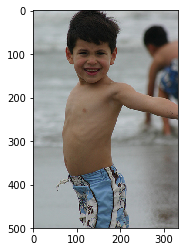

Candidate:  boy in red swimsuit is jumping into the water 
Reference:  boy in his blue swim shorts at the beach
Reference:  boy smiles for the camera at beach
Reference:  young boy in swimming trunks is walking with his arms outstretched on the beach
Reference:  children playing on the beach
Reference:  the boy is playing on the shore of an ocean
Bleu_1 score:  0.4444444444444444
Bleu_2 score:  0.23570226039551587
Bleu_3 score:  2.1262855015914924e-93
Bleu_4 score:  7.241926111174567e-155


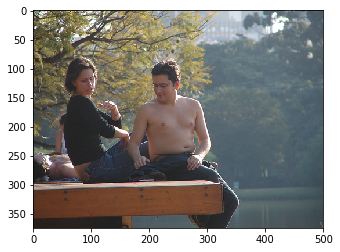

Candidate:  man in black shirt is sitting on the edge of fountain 
Reference:  lady and man with no shirt sit on dock
Reference:  man and woman are sitting on dock together
Reference:  man and woman sitting on dock
Reference:  man and woman sitting on deck next to lake
Reference:  shirtless man and woman sitting on dock
Bleu_1 score:  0.36363636363636365
Bleu_2 score:  0.19069251784911848
Bleu_3 score:  1.8724210775784562e-93
Bleu_4 score:  6.513869329968086e-155


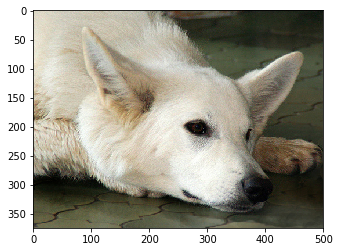

Candidate:  brown dog is playing with stick 
Reference:  closeup of white dog that is laying its head on its paws
Reference:  large white dog lying on the floor
Reference:  white dog has its head on the ground
Reference:  white dog is resting its head on tiled floor with its eyes open
Reference:  white dog rests its head on the patio bricks
Bleu_1 score:  0.423240862445307
Bleu_2 score:  0.2676810248362385
Bleu_3 score:  2.146944984485809e-93
Bleu_4 score:  7.100514228897259e-155


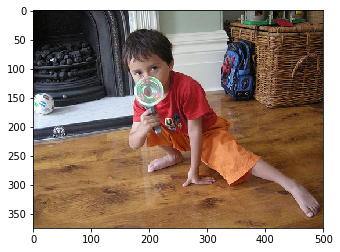

Candidate:  young boy in pink shirt is playing with toy 
Reference:  boy with toy gun
Reference:  little boy in orange shorts playing with toy
Reference:  young boy with his foot outstretched aims toy at the camera in front of fireplace
Reference:  young child plays with his new lightup toy
Reference:  boy with toy gun pointed at the camera
Bleu_1 score:  0.6666666666666666
Bleu_2 score:  0.5773502691896257
Bleu_3 score:  0.4011753235797363
Bleu_4 score:  5.705336763108155e-78


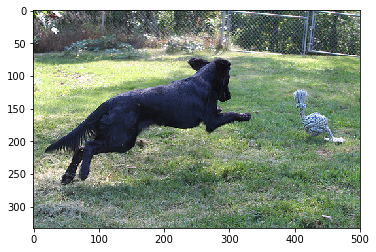

Candidate:  black dog is running through the grass 
Reference:  black dog jumping to catch rope toy
Reference:  black dog playing fetch with ball of rope
Reference:  black dog pounces to get rope toy
Reference:  black dog running after his rope toy
Reference:  large black dog is playing in grassy yard
Bleu_1 score:  0.5714285714285714
Bleu_2 score:  0.4364357804719847
Bleu_3 score:  0.37519859868268624
Bleu_4 score:  5.395774370246974e-78


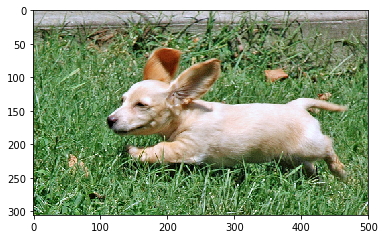

Candidate:  brown dog is running through the grass 
Reference:  little tan dog with large ears running through the grass
Reference:  playful dog is running through the grass
Reference:  small dogs ears stick up as it runs in the grass
Reference:  the small dog is running across the lawn
Reference:  this is small beige dog running through grassy field
Bleu_1 score:  0.8571428571428571
Bleu_2 score:  0.8451542547285166
Bleu_3 score:  0.8454512788430708
Bleu_4 score:  0.8091067115702212


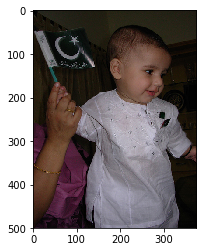

Candidate:  young boy in red shirt is eating 
Reference:  baby in white garment holds flag with crescent moon and star
Reference:  baby is holding small black flag with moon and star on it
Reference:  baby wearing white gown waves muslim flag
Reference:  little toddler dressed in white is smiling while lady helps him wave flag
Reference:  baby in white outfit holding black and white flag
Bleu_1 score:  0.2857142857142857
Bleu_2 score:  7.973301625706314e-155
Bleu_3 score:  1.7586776545063733e-185
Bleu_4 score:  1.331960397810445e-231


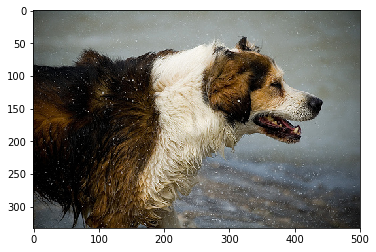

Candidate:  black dog is running through water 
Reference:  brown and white dog stands outside while it snows
Reference:  dog is looking at something near the water
Reference:  furry dog attempts to dry itself by shaking the water off its coat
Reference:  white and brown dog shaking its self dry
Reference:  the large brown and white dog shakes off water
Bleu_1 score:  0.35826565528689464
Bleu_2 score:  0.2265870956238665
Bleu_3 score:  1.8173496937128004e-93
Bleu_4 score:  6.010455532087301e-155


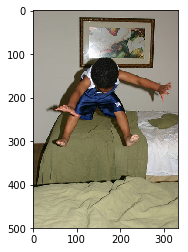

Candidate:  young boy is sleeping on bed 
Reference:  boy is jumping on bed
Reference:  boy jumped up from the green bed
Reference:  boy jumps from one bed to another
Reference:  small child is jumping on bed
Reference:  the boy in blue shorts is bouncing on the bed
Bleu_1 score:  0.6666666666666666
Bleu_2 score:  0.5163977794943222
Bleu_3 score:  3.404034469286905e-93
Bleu_4 score:  1.0719249972567852e-154


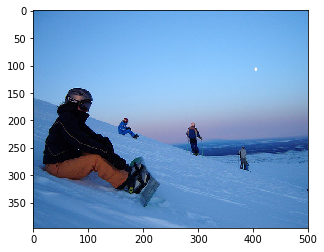

Candidate:  man in red shirt is climbing up cliff 
Reference:  snowboarder sits on slope with skiers and boarders nearby
Reference:  snowboarder takes rest on the mountainside
Reference:  snowboarders sitting in the snow while skiers take the hill
Reference:  the snowboarder is sitting down
Reference:  two skiers stand two sit on slopes
Bleu_1 score:  0.25
Bleu_2 score:  7.458340731200295e-155
Bleu_3 score:  1.6896185209462903e-185
Bleu_4 score:  1.2882297539194154e-231


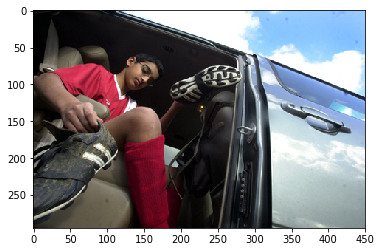

Candidate:  man in black shirt is sitting on the sidewalk 
Reference:  boy dressed in soccer attire and holding his shoes getting out of car
Reference:  boy in red soccer strip is holding his boots in his hand whilst stepping out of car
Reference:  boy in glasses is wearing red shirt
Reference:  child getting out of the car wearing soccer shoes
Reference:  young boy gets out of the van and prepares his shoes for wear during soccer game
Bleu_1 score:  0.4444444444444444
Bleu_2 score:  9.94445430826712e-155
Bleu_3 score:  2.0079454189758342e-185
Bleu_4 score:  1.4875195904069663e-231


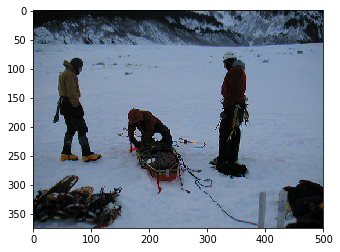

Candidate:  group of people are playing in the snow 
Reference:  three men are setting up sledge on snowy plain
Reference:  three men loading items on sled
Reference:  three people and sled
Reference:  three people are standing in the snow preparing an ice fishing boat
Reference:  three people in the snow put their gear in order
Bleu_1 score:  0.5515605641153721
Bleu_2 score:  0.45673553902495045
Bleu_3 score:  0.3472472253757243
Bleu_4 score:  4.954356947008765e-78


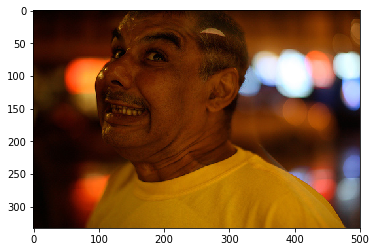

Candidate:  man in black shirt is holding drink 
Reference:  man in yellow grimaces
Reference:  man wearing yellow shirt with dramatic look on his face
Reference:  the man in the yellow tshirt is pulling large grin on his face
Reference:  there is man wearing yellow shirt and grimacing
Reference:  this man is smiling very big at the camera
Bleu_1 score:  0.4953587998572467
Bleu_2 score:  0.267524327879111
Bleu_3 score:  2.1667283753546873e-93
Bleu_4 score:  7.183445846156676e-155


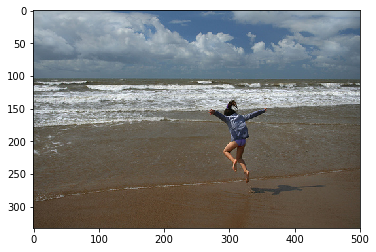

Candidate:  man is walking through the water 
Reference:  girl in blue is jumping on the shore as small waves approach her
Reference:  girl leaps into the air while standing by the ocean
Reference:  young longhaired girl on the beach is jumping in the air
Reference:  the girl is running into the ocean from the shore
Reference:  the girls is jumping into the air on the beach
Bleu_1 score:  0.17113903967753066
Bleu_2 score:  4.421625271317475e-155
Bleu_3 score:  9.45672212180377e-186
Bleu_4 score:  7.107197028258987e-232


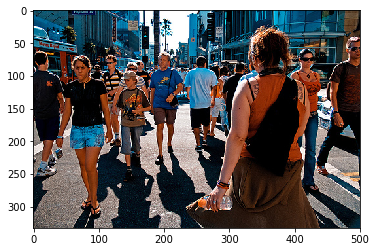

Candidate:  group of people are standing in front of the ocean 
Reference:  crowd of people walk down busy sidewalk
Reference:  group of different people are walking in all different directions in city
Reference:  group of people walking city street in warm weather
Reference:  busy intersection in the summer time in city
Reference:  people in summer clothes are walking on the sidewalk of large city
Bleu_1 score:  0.6
Bleu_2 score:  0.4472135954999579
Bleu_3 score:  0.33066025977478425
Bleu_4 score:  4.856474469839072e-78


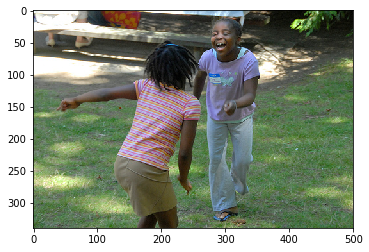

Candidate:  two girls play in the air 
Reference:  two children are laughing in the grass
Reference:  two girls laughing outside in yard
Reference:  two girls standing on grass face each other
Reference:  two young girls are playing and laughing in green grassy yard
Reference:  two young girls playing together
Bleu_1 score:  0.6666666666666666
Bleu_2 score:  0.5163977794943222
Bleu_3 score:  3.404034469286905e-93
Bleu_4 score:  1.0719249972567852e-154


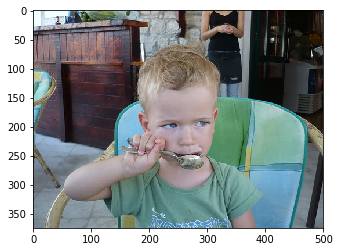

Candidate:  young boy in pretend bed 
Reference:  boy eats with spoon
Reference:  little boy holds spoon up to his mouth
Reference:  little boy is eating his food off of spoon while sitting on patio
Reference:  small child dressed in green is eating with spoon
Reference:  young child holds spoon to its mouth while sitting in chair
Bleu_1 score:  0.6
Bleu_2 score:  1.155441177691175e-154
Bleu_3 score:  2.1971111798180458e-185
Bleu_4 score:  1.6034157163765524e-231


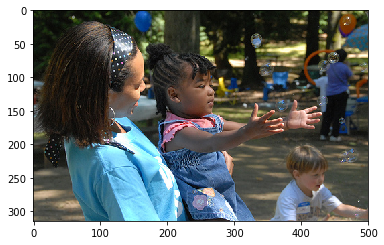

Candidate:  two girls are playing with toys 
Reference:  lady holds little girl who is trying to catch bubbles
Reference:  woman is holding little girl who is trying to catch bubbles
Reference:  woman with holding young girl playing with bubbles at picnic
Reference:  young woman in blue shirt stands holding young girl in denim dress
Reference:  there is woman holding her baby daughter while the daughter claps
Bleu_1 score:  0.17113903967753066
Bleu_2 score:  0.13256373011140135
Bleu_3 score:  1.1530451067989366e-93
Bleu_4 score:  3.891524296988902e-155


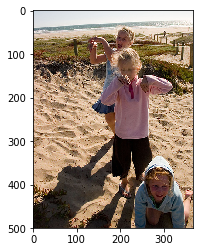

Candidate:  little girl in pink shirt is running on the beach 
Reference:  three children are playing in sand near to the beach
Reference:  three children playing in sand at beach
Reference:  three girls play in the sand
Reference:  three little blond girls two in blue one in pink play on sunny beach
Reference:  three young girls dance on the beach in the sand
Bleu_1 score:  0.6
Bleu_2 score:  0.4472135954999579
Bleu_3 score:  0.33066025977478425
Bleu_4 score:  4.856474469839072e-78


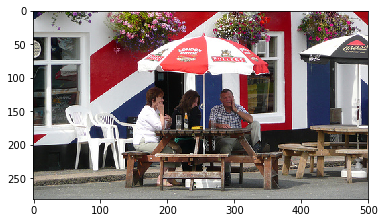

Candidate:  man is sitting on the sidewalk with his umbrella in his hand 
Reference:  couple of people sit outdoors at table with an umbrella and talk
Reference:  three people are sitting at an outside picnic bench with an umbrella
Reference:  three people sit at an outdoor cafe
Reference:  three people sit at an outdoor table in front of building painted like the union jack
Reference:  three people sit at picnic table outside of building painted like union jack
Bleu_1 score:  0.4166666666666667
Bleu_2 score:  9.628676480759687e-155
Bleu_3 score:  1.96944241247487e-185
Bleu_4 score:  1.4637115948630222e-231


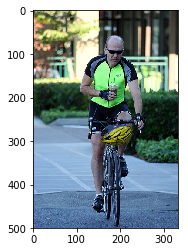

Candidate:  man in black shirt is riding bicycle down the street 
Reference:  biker enjoys coffee
Reference:  man in bright green shirt and sunglasses is riding bicycle through the streets whilst drinking latte
Reference:  man in bright green shirt riding bicycle in paved courtyard carying drink
Reference:  man rides on his bike with one hand and holds drink with the other
Reference:  man riding bike wearing green shirt with drink in his hand
Bleu_1 score:  0.6333861926251716
Bleu_2 score:  0.43707799729361313
Bleu_3 score:  0.3133549729119345
Bleu_4 score:  4.566972108023278e-78


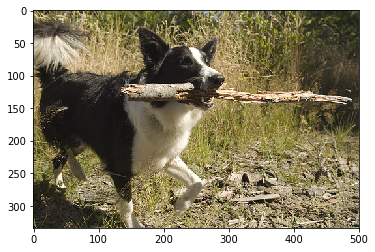

Candidate:  two dogs play with each other 
Reference:  black and white dog carrying large stick
Reference:  black and white dog is carrying stick in its mouth
Reference:  black and white dog walking through the grass with long stick in his mouth
Reference:  dog holds stick in its mouth
Reference:  dog trots across the ground with large stick in his mouth
Bleu_1 score:  0.16666666666666669
Bleu_2 score:  6.08970970641905e-155
Bleu_3 score:  1.4961022763680928e-185
Bleu_4 score:  1.1640469867513693e-231


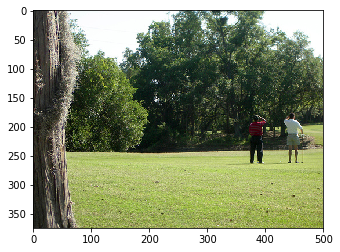

Candidate:  two girls are playing in the woods 
Reference:  one man in red shirt and black pants with man in white shirt and tan shorts golfing
Reference:  tree in the foreground two men playing golf in the background
Reference:  two golfers are standing on the fairway looking off into the distance
Reference:  two golfers look off into the distance with hands blocking the sun
Reference:  two men looking into the distance on golf course
Bleu_1 score:  0.5367694950537757
Bleu_2 score:  0.2592842992895377
Bleu_3 score:  2.008331527017773e-93
Bleu_4 score:  6.58443108435194e-155


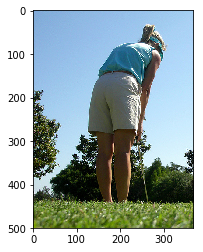

Candidate:  young boy in pink shirt is jumping into the air 
Reference:  girl is getting ready to swing the club
Reference:  woman in shorts and blue sleeveless shirt leans over golf club
Reference:  woman is taking swing with golf club
Reference:  woman wearing blue shirt and hat with khaki shorts plays golf
Reference:  woman wearing blue begins golf swing
Bleu_1 score:  0.36193496721438384
Bleu_2 score:  8.536360807345964e-155
Bleu_3 score:  1.760334530221513e-185
Bleu_4 score:  1.3109733799909448e-231


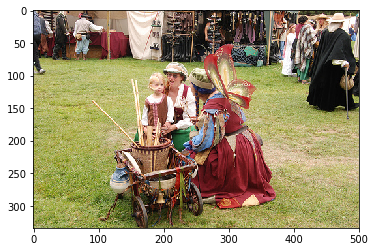

Candidate:  group of children are playing with their arms in the street 
Reference:  group of people in costume at renaissance fair
Reference:  people in costume at renaissance fair
Reference:  two woman in colorful costumes look at little girl wearing brown vest
Reference:  two women and child are sitting by cart of arrows in front of booth at medieval fayre
Reference:  two women crouch near small child at medieval fair
Bleu_1 score:  0.3320366241026409
Bleu_2 score:  0.1741214746376982
Bleu_3 score:  1.709709027118894e-93
Bleu_4 score:  5.94781875096292e-155


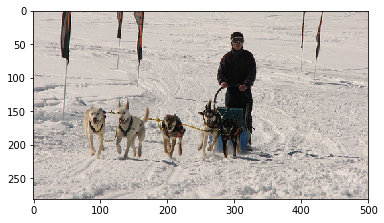

Candidate:  group of people are playing in the snow 
Reference:  group of dogs pull person on dog sled up hill
Reference:  dogsled rider pulled past flags on snowy hill
Reference:  dogs pulling sled in sled race
Reference:  five sled dogs are pulling person on sled through the snow
Reference:  the man is mushing his dogs on snow trail
Bleu_1 score:  0.75
Bleu_2 score:  0.46291004988627577
Bleu_3 score:  3.18787508243652e-93
Bleu_4 score:  1.0148936155293581e-154


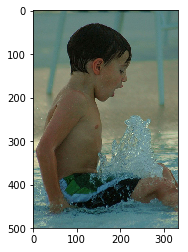

Candidate:  boy in swimming pool 
Reference:  boy sitting in water
Reference:  small boy is sitting in the water and water is splashing up through his legs
Reference:  young boy in swimming suit sits in water
Reference:  young boy sitting on water jet in pool
Reference:  little boy sitting in water with fountain coming up through his lap
Bleu_1 score:  1.0
Bleu_2 score:  0.816496580927726
Bleu_3 score:  0.7192230933248643
Bleu_4 score:  9.280167055464391e-78


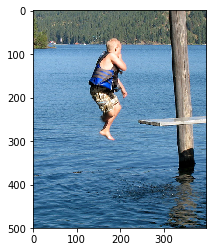

Candidate:  man in black wetsuit is canoeing in the ocean 
Reference:  blonde boy wearing blue life vest and camo shorts jumps off diveboard into blue lake
Reference:  boy diving backward off pier in large lake
Reference:  boy in blue life jacket jumps into the water
Reference:  boy in blue life jacket jumps off board into the lake
Reference:  boy is holding his nose and jumping off diving board backwards into lake
Bleu_1 score:  0.3333333333333333
Bleu_2 score:  8.612150057732663e-155
Bleu_3 score:  1.8419179593432007e-185
Bleu_4 score:  1.384292958842266e-231


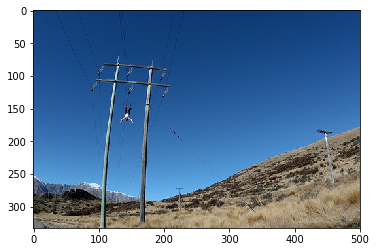

Candidate:  man is sitting on the edge of large rock 
Reference:  person hanging from telephone pole near the mountains
Reference:  person is hanging in the air from the power lines
Reference:  person is hanging upside down from power lines
Reference:  person hanging upside down from poles
Reference:  someone is suspended from electrical wires
Bleu_1 score:  0.2222222222222222
Bleu_2 score:  7.031791076575252e-155
Bleu_3 score:  1.6309584783156364e-185
Bleu_4 score:  1.2508498911928379e-231


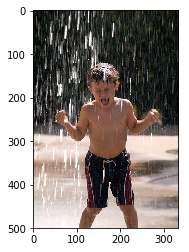

Candidate:  boy in red shorts is jumping into the water 
Reference:  boy enjoys rain shower
Reference:  boy in bathing trunks is standing under water shower
Reference:  boy in swim trunks screams while being sprayed with water
Reference:  boy is squinting while being sprayed with water from flat ground surface
Reference:  boy wearing black swimming trunks is standing in fountain
Bleu_1 score:  0.4444444444444444
Bleu_2 score:  0.23570226039551587
Bleu_3 score:  2.1262855015914924e-93
Bleu_4 score:  7.241926111174567e-155


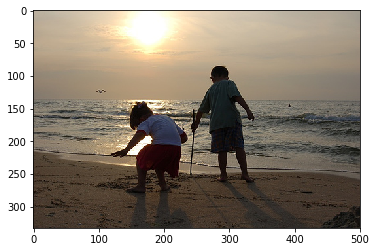

Candidate:  two girls are playing badminton in the grass 
Reference:  boy and girl playing on the beach
Reference:  small boy and girls are playing in the sand on the beach
Reference:  two children one of which is holding stick are standing on the beach as the sun begins to set
Reference:  two children on the beach silhouetted by the setting sun
Reference:  two young children playing with sticks at the beach
Bleu_1 score:  0.75
Bleu_2 score:  0.5669467095138409
Bleu_3 score:  0.41560423878293357
Bleu_4 score:  5.87583260478785e-78


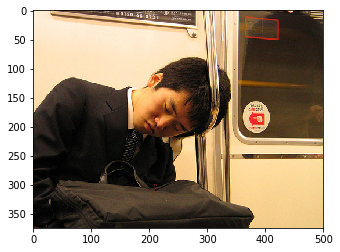

Candidate:  man in black shirt is sitting on the street 
Reference:  man sleeping with bag on his lap on public transportation
Reference:  man who has fallen asleep on public transportation
Reference:  an asian man in suit on the subway asleep
Reference:  tired business man takes quick nap while riding the train
Reference:  young man in suit and tie leans against railing to take nap on public transit
Bleu_1 score:  0.4444444444444444
Bleu_2 score:  0.33333333333333337
Bleu_3 score:  2.6177645164606753e-93
Bleu_4 score:  8.612150057732663e-155


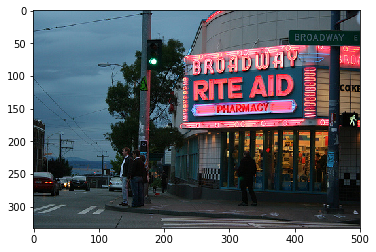

Candidate:  man is sitting on the balcony of the sidewalk 
Reference:  people stand on street corner at dusk with pharmacy in the background
Reference:  people stand outside of the rite aid pharmacy on broadway
Reference:  people waiting to cross the street in front of pharmacy with lit up sign
Reference:  some people look to cross the street in front of drug store
Reference:  this is picture of broadway rite aid pharmacy that has bright neon sign and people are prepared to cross the street in front of it
Bleu_1 score:  0.39770636302860873
Bleu_2 score:  0.2109156496639261
Bleu_3 score:  1.9026838655964303e-93
Bleu_4 score:  6.480360213743594e-155


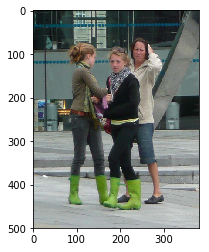

Candidate:  two children are playing on trampoline 
Reference:  three women standing on city street
Reference:  three women walk down the street
Reference:  two girls and woman walking on the sidewalk
Reference:  two girls in bright green boots and woman are together
Reference:  two young ladies in green boots are walking through an urban area while an older lady wearing black shoes follows them
Bleu_1 score:  0.5
Bleu_2 score:  1.0547686614863434e-154
Bleu_3 score:  2.0801644027471386e-185
Bleu_4 score:  1.5319719891192393e-231


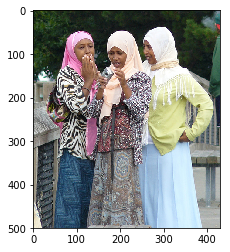

Candidate:  two girls are playing with toys 
Reference:  three females wearing head scarves standing together
Reference:  three muslim women are looking at camera
Reference:  three women in dresses and head scarves outside
Reference:  three women in head scarves examine camera
Reference:  three women with head scarves and long skirts
Bleu_1 score:  0.28216057496353797
Bleu_2 score:  7.2900276358863456e-155
Bleu_3 score:  1.5591498913318325e-185
Bleu_4 score:  1.171778691554733e-231


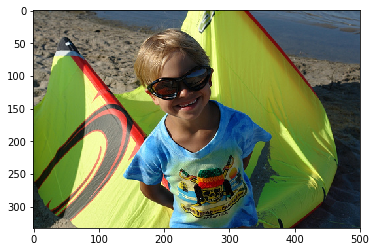

Candidate:  young boy is sitting on the edge of the water 
Reference:  blond boy in blue tee shirts stands smiling before craft of green nylon fabric
Reference:  child poses wearing glasses near water outside
Reference:  small girl smiling on the beach
Reference:  young kid at the beach
Reference:  young man wearing swimming goggles wearing blue shirt with pirate skull on it
Bleu_1 score:  0.6
Bleu_2 score:  0.25819888974716104
Bleu_3 score:  2.245825205383813e-93
Bleu_4 score:  7.57965434483665e-155


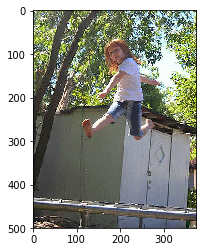

Candidate:  young boy in red shirt is jumping on swing 
Reference:  barefoot redheaded girl jumping over rail
Reference:  girl jumps on the trampoline
Reference:  young girl jumping over railing or ladder on its side
Reference:  the small red haired girl jumps on the trampoline under the tree by the shed
Reference:  the young child with red hair bounced on the trampoline
Bleu_1 score:  0.39770636302860873
Bleu_2 score:  8.898688699301465e-155
Bleu_3 score:  1.7967885069168788e-185
Bleu_4 score:  1.331091014027761e-231


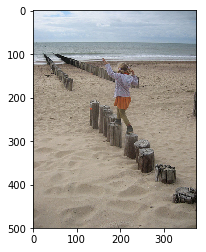

Candidate:  two people are sitting on the beach 
Reference:  blonde girl is stepping on vertical logs in the sand
Reference:  little girl is walking along line of logs on sandy beach
Reference:  young girl balances on wooden pylons at the beach
Reference:  young girl is walking on stumps on the beach next to the ocean
Reference:  girl walking along the tops of wooden posts set into sand on beach
Bleu_1 score:  0.32206169703226534
Bleu_2 score:  0.284031719055601
Bleu_3 score:  0.25863985552473195
Bleu_4 score:  3.7734183673994593e-78


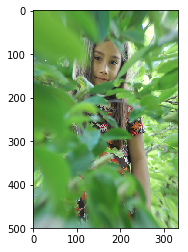

Candidate:  young boy in pink shirt is playing on bed 
Reference:  girl in flowered dress peaking through some leaves
Reference:  girl peeks through the leaves on tree
Reference:  girl peeks through the green leaves
Reference:  young girl peers through the green foliage
Reference:  young girl face looking through leaves
Bleu_1 score:  0.3333333333333333
Bleu_2 score:  8.612150057732663e-155
Bleu_3 score:  1.8419179593432007e-185
Bleu_4 score:  1.384292958842266e-231


KeyboardInterrupt: 

In [115]:
for key, desc_list in test_descriptions.items():
    candidate = generate_desc(model, tokenizer, test_features[key], max_length)
    references = [d.split() for d in desc_list]
    images = '../../datasets/flickr8k/Flicker8k_Dataset/'
    plot_image(images + key + ".jpg")
    print("Candidate: ", candidate[9:-6])
    print_references(references)
    calculate_bleu_score(references,candidate.split())


In [152]:
candidate = ['two', 'dogs', 'are', 'playing','with', 'each','other']
reference = [['two', 'dogs', 'play','with', 'each','other']]

score_1 = sentence_bleu(reference, candidate,weights=(1,0,0,0))
score_2 = sentence_bleu(reference, candidate,weights=(0.5,0.5,0,0))
print("Bleu_1: ", score_1) #5/7
print("Bleu_2: ", score_2)

Bleu_1:  0.7142857142857143
Bleu_2:  0.5976143046671969


In [154]:
candidate_lem = lemmatize_sentense(' '.join(candidate))
reference_lem = [lemmatize_sentense(' '.join(reference[0]))]
print("Candidae: ", candidate_lem)
print("Reference: ", reference_lem)
score_1 = sentence_bleu(reference_lem, candidate_lem, weights=(1,0,0,0))
score_2 = sentence_bleu(reference_lem, candidate_lem, weights=(0.5,0.5,0,0))
print("Bleu_1: ", score_1) #6/7
print("Bleu_2: ", score_2)

Candidae:  ['two', 'dog', 'be', 'play', 'with', 'each', 'other']
Reference:  [['two', 'dog', 'play', 'with', 'each', 'other']]
Bleu_1:  0.8571428571428571
Bleu_2:  0.7559289460184544
